<a href="https://colab.research.google.com/github/Nirannoel/demo/blob/main/APADPTING%20PRETRAINED%20PIPELINE%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq pyannote.audio==2.1.1
!pip install -qq rich

     |████████████████████████████████| 390 kB 6.2 MB/s 
     |████████████████████████████████| 47 kB 5.9 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 217 kB 61.4 MB/s 
     |████████████████████████████████| 111 kB 32.9 MB/s 
     |████████████████████████████████| 182 kB 78.7 MB/s 
     |████████████████████████████████| 60 kB 9.6 MB/s 
     |████████████████████████████████| 512 kB 73.5 MB/s 
     |████████████████████████████████| 585 kB 61.0 MB/s 
     |████████████████████████████████| 41 kB 594 kB/s 
     |████████████████████████████████| 498 kB 68.4 MB/s 
     |████████████████████████████████| 51 kB 215 kB/s 
     |████████████████████████████████| 117 kB 82.0 MB/s 
     |████████████████████████████████| 139 kB 61.1 MB/s 
     |████████████████████████████████| 348 kB 64.8 MB/s 
     |████████████████████████████████| 81 kB 12.4 MB/s 
     |████████████████████████████████| 209 kB 80.9 MB/s 
     |███████████████████

In [ ]:
# download AMI-SDM mini corpus
%cd /content/
!git clone https://github.com/pyannote/AMI-diarization-setup
%cd /content/AMI-diarization-setup/pyannote/
!bash download_ami_sdm_mini.sh

/content
Cloning into 'AMI-diarization-setup'...
remote: Enumerating objects: 977, done.
remote: Counting objects: 100% (977/977), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 977 (delta 390), reused 949 (delta 369), pack-reused 0
Receiving objects: 100% (977/977), 1.67 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (390/390), done.
/content/AMI-diarization-setup/pyannote
ES2002a.Array1-01.w 100%[===================>]  38.84M  13.7MB/s    in 2.8s    
2022-12-09 06:15:08 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Array1-01.wav [40727594/40727594] -> "amicorpus/ES2002a/audio/ES2002a.Array1-01.wav" [1]
ES2003a.Array1-01.w 100%[===================>]  34.78M  13.0MB/s    in 2.7s    
2022-12-09 06:15:12 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2003a/audio/ES2003a.Array1-01.wav [36472536/36472536] -> "amicorpus/ES2003a/audio/ES2003a.Array1-01.wav" [1]
ES2004a.Array1-01.w 100%[===================>]  32.0

In [ ]:
# preparing notebook for visualization purposes
# (only show outputs between t=180s and t=240s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(210, 240)

In [ ]:
!PYANNOTE_DATABASE_CONFIG="/content/AMI-diarization-setup/pyannote/database.yml" pyannote-database info AMI-SDM.SpeakerDiarization.mini

train
   28 files
   8h46m annotated
   6h11m of speech (71%)
   112 speakers
development
   3 files
   0h56m annotated
   0h40m of speech (72%)
   12 speakers
test
   3 files
   0h56m annotated
   0h39m of speech (70%)
   12 speakers


In [ ]:
import os
os.environ["PYANNOTE_DATABASE_CONFIG"] = "/content/AMI-diarization-setup/pyannote/database.yml"
from pyannote.database import get_protocol, FileFinder
dataset = get_protocol("AMI-SDM.SpeakerDiarization.mini", {"audio": FileFinder()})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from pyannote.audio import Pipeline
pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True) 

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/318 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
# this takes approximately 2min to run on Google Colab GPU
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

for file in dataset.test():
    # apply pretrained pipeline
    file["pretrained pipeline"] = pretrained_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["pretrained pipeline"], uem=file["annotated"])

print(f"The pretrained pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

The pretrained pipeline reaches a Diarization Error Rate (DER) of 32.5% on AMI-SDM.SpeakerDiarization.mini test set.


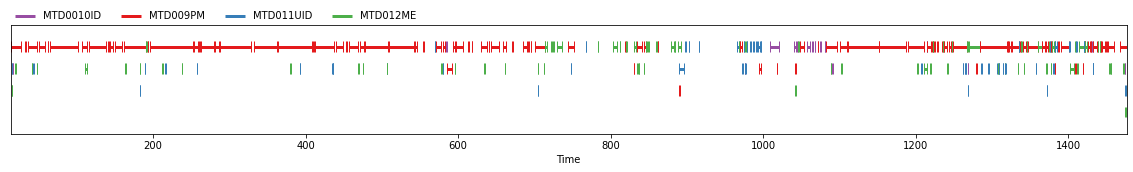

In [ ]:
file["annotation"]

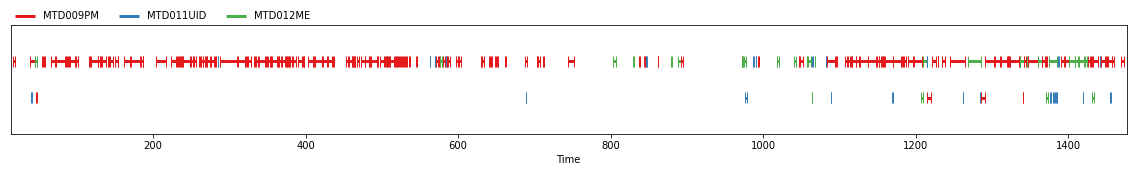

In [ ]:
file["pretrained pipeline"]

In [ ]:
from pyannote.audio import Model
model = Model.from_pretrained("pyannote/segmentation", use_auth_token=True)

In [ ]:
from pyannote.audio.tasks import Segmentation
task = Segmentation(dataset, 
                    duration=model.specifications.duration, 
                    max_num_speakers=len(model.specifications.classes), 
                    batch_size=32,
                    num_workers=2, 
                    loss="bce", 
                    vad_loss="bce")
model.task = task
model.setup(stage="fit")

Protocol AMI-SDM.SpeakerDiarization.mini does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


In [ ]:
# this takes approximately 15min to run on Google Colab GPU
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

model.configure_optimizers = MethodType(configure_optimizers, model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu", 
                  callbacks=callbacks, 
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [32, 1, 80000] │                              [32, 60, 293] │
│ 1 │ lstm              │ LSTM             │  1.4 M │  [32, 293, 60] │    [[32, 293, 256], [[8, 32, 128], [8, 32, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    387 │ [32, 293, 128] │                               [32, 293, 3] │
│ 4 │ activation        │ Sigmoid          │      0 │   [32, 293, 3] │                               [32, 293, 3] │
│ 5 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

In [ ]:
# save path to the best checkpoint for later use
finetuned_model = checkpoint.best_model_path

# uncomment to download the checkpoint
#from google.colab import files
#files.download(finetuned_model)

In [ ]:
pretrained_hyperparameters = pretrained_pipeline.parameters(instantiated=True)
pretrained_hyperparameters

{'segmentation': {'min_duration_off': 0.5817029604921046,
  'threshold': 0.4442333667381752},
 'clustering': {'method': 'centroid',
  'min_cluster_size': 15,
  'threshold': 0.7153814381597874}}

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.pipeline import Optimizer

pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    clustering="OracleClustering",  
)
# as reported in the technical report, min_duration_off can safely be set to 0.0
pipeline.freeze({"segmentation": {"min_duration_off": 0.0}})

optimizer = Optimizer(pipeline)
dev_set = list(dataset.development())

iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best segmentation threshold so far: {iteration['params']['segmentation']['threshold']}")
    if i > 20: break   # 50 iterations should give slightly better results

Best segmentation threshold so far: 0.6560190630560168
Best segmentation threshold so far: 0.5988606854223582
Best segmentation threshold so far: 0.5988606854223582
Best segmentation threshold so far: 0.5988606854223582
Best segmentation threshold so far: 0.5988606854223582
Best segmentation threshold so far: 0.28198858624698203
Best segmentation threshold so far: 0.28198858624698203
Best segmentation threshold so far: 0.28198858624698203
Best segmentation threshold so far: 0.28198858624698203
Best segmentation threshold so far: 0.28198858624698203
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best segmentation threshold so far: 0.3639820497439319
Best 

In [ ]:
best_segmentation_threshold = optimizer.best_params["segmentation"]["threshold"]

In [ ]:
# this takes approximately 5min to run on Google Colab GPU
pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

pipeline.freeze({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
    },
})

optimizer = Optimizer(pipeline)
iterations = optimizer.tune_iter(dev_set, show_progress=False)
best_loss = 1.0
for i, iteration in enumerate(iterations):
    print(f"Best clustering threshold so far: {iteration['params']['clustering']['threshold']}")
    if i > 20: break  # 50 iterations should give slightly better results

Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 1.7919615985734545
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648238978
Best clustering threshold so far: 0.6026083648

In [ ]:
best_clustering_threshold = optimizer.best_params['clustering']['threshold']

In [ ]:
# this takes approximately 2min to run on Google Colab GPU
finetuned_pipeline = SpeakerDiarization(
    segmentation=finetuned_model,
    embedding=pretrained_pipeline.embedding,
    embedding_exclude_overlap=pretrained_pipeline.embedding_exclude_overlap,
    clustering=pretrained_pipeline.klustering,
)

finetuned_pipeline.instantiate({
    "segmentation": {
        "threshold": best_segmentation_threshold,
        "min_duration_off": 0.0,
    },
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": best_clustering_threshold,
    },
})

metric = DiarizationErrorRate()

for file in dataset.test():
    # apply finetuned pipeline
    file["finetuned pipeline"] = finetuned_pipeline(file)

    # evaluate its performance
    metric(file["annotation"], file["finetuned pipeline"], uem=file["annotated"])

print(f"The finetuned pipeline reaches a Diarization Error Rate (DER) of {100 * abs(metric):.1f}% on {dataset.name} test set.")

The finetuned pipeline reaches a Diarization Error Rate (DER) of 28.2% on AMI-SDM.SpeakerDiarization.mini test set.


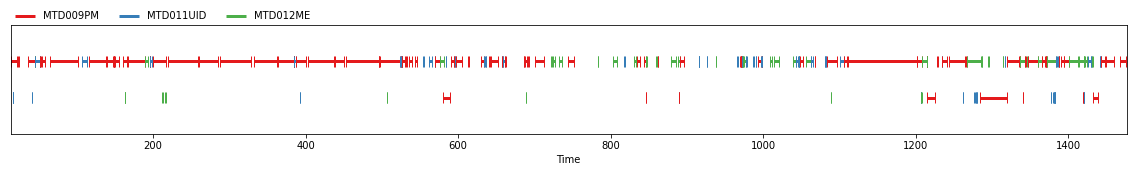

In [18]:
file["finetuned pipeline"]

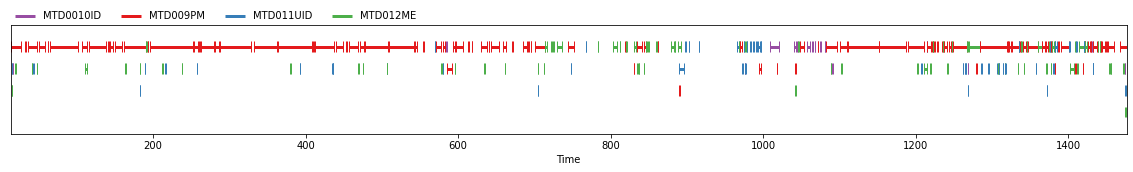

In [19]:
file["annotation"]